In [1]:
!ls

HFClassifier.ipynb	  logs			  testModel_v1.keras
Plotter.ipynb		  models		  testModel_v1_old.keras
Predictor_final.ipynb	  output_file.root	  testModel_v1_older.keras
Untitled.ipynb		  output_file_final.root  testModel_v1_savedmodel
Untitled1.ipynb		  outputs		  trained_scaler.pkl
Untitled2.ipynb		  predict.ipynb		  visualize.ipynb
Working_prediction.ipynb  testModel_v1.h5
Wto3pi_Classifier.ipynb   testModel_v1.hdf5


In [2]:
# import sys
import uproot
import numpy as np
import pandas as pd
import awkward as ak
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
import h5py

Variables we need from ROOT files

In [3]:
# Variables used for selection. These shouldn't be normalized or else the cuts will make no sense
selection_vars = [
    'run', 'event', 'hf_match',
]

# Variables with integer or weird scale...
special_scale = {
    'nvtx': [-4, 4],
    'nele': [-4, 4],
    'nhf' : [-4, 4],
    'nmc' : [-4, 4],
  }

# Variables that could be used as NN input. These should be normalized
scaled_vars = [
    #'ele_pt', 'ele_eta', 'ele_phi', 'ele_mediumID', 
    'hf_en', 'hf_pt', 'hf_eta', 'hf_phi', 'hf_iso', 'hf_ecal', 'hf_hcal'
    #'mc_pt', 'mc_eta', 'mc_phi',
]


In [4]:
#@title File Loading
def loadFiles( ifile, open_file, itree):
    isData = 'data' in ifile.lower() 
    syst = itree.split(';', 1)[0] # remove any cycle info (Events;2)
    filename = ifile.split('/')[-1]

    todrop = []
    columns = scaled_vars + selection_vars  + list(special_scale.keys()) 

    # for classifying, we want to score ALL triplets, so that we can select whichever one we want later
    input_array = open_file[itree].arrays(columns, library='ak') #from the itree loads the arrays corresponding to specific coloumns using ak array used for handling irregular data structure
    #print(f'Input Length: {len(input_array)}')

    #print(input_array['ele_pt'].layout)
    #print(input_array['hf_pt'].layout)

    event_vars = [ v for v in columns if "hf_" not in v]
    hf_vars = [ v for v in columns if "hf_" in v]
    
    # Flatten and create new
    slim_df = pd.DataFrame()
    for s in event_vars:
        slim_df[s] = ak.flatten( ak.broadcast_arrays(input_array[s], input_array['hf_en'])[0], axis=1)
    
    for m in hf_vars:
        slim_df[m] = ak.flatten( input_array[m], axis=1)
        
    print(f'Flattened Length: {len(slim_df)}')
    slim_df['idx'] = ak.flatten( ak.broadcast_arrays( np.array([i for i in range(0, len(input_array['event']))]), input_array['hf_en'])[0], axis=1)
            
    slim_df = slim_df.dropna(axis=0, how='any')  # drop events with a NaN
    slim_df = slim_df.drop_duplicates()  # drop duplicate events

    # get variables that require special scaling
    special_scale_df = slim_df[special_scale.keys()]

    # get variables needed for selection (so they aren't normalized)
    selection_df = slim_df[selection_vars]

    # sets a uniform initial weight for all events.
    slim_df['evtwt'] = np.ones(len(slim_df))

    # get just the weights (they are scaled differently)
    weights = slim_df['evtwt']
    event = slim_df['event']
    index = slim_df['idx']

    #as the selection variables are removed from slim_df as they are stored in a seprately in selection_df and must not be normalized
    todrop += selection_vars

    slim_df = slim_df.drop(todrop, axis=1)
    slim_df = slim_df.astype('float64')

    # add the event label
    if not isData:
        isSignal = selection_df['hf_match'].apply(lambda x: x >= 0)
        print(f'# of signal:     {sum(isSignal)}')
        print(f'# of background: {len(isSignal) - sum(isSignal)}')

    # scale event weights between 1 - 2
    # weights = MinMaxScaler( feature_range=(1., 2.)).fit_transform( weights.values.reshape(-1, 1)) # -1 is wildcard here, let numpy figure out rows, 1 columns

    print(f'{filename}: {len(slim_df)}') #, {sum(weights) / len(weights):.6f}')
    return {
        'slim_df': slim_df,
        'special_scale': special_scale_df,
        'selection_df': selection_df,
        'isSignal': isSignal,
        'weights': weights,
        'event': event,
        'index': index,
        'somenames': np.full(len(slim_df), filename.split('.root')[0]),
    }, syst.replace(';1', '')

In [5]:
from glob import glob

def expandGlob( inputglobs):
    return inputglobs if not any( '*' in f for f in inputglobs) else list(ak.flatten([ glob(f'{f}') for f in inputglobs]))

In [6]:
def preprocess( files_to_process):
    all_data = {}

    default_object = {
        'unscaled': pd.DataFrame(dtype='float64'),
        'special_scale': pd.DataFrame(),
        'selection': pd.DataFrame(),
        'norm': pd.DataFrame(),
        'isSignal': np.array([]),
        'weights': np.array([]),
        'event': np.array([]),
        'index': np.array([]),
        'names': np.array([]),
    }

    # check for globs
    input_files = expandGlob( files_to_process)

    treename = 'miniTree'
    for ifile in input_files:
        open_file = uproot.open(ifile)
        if not any([treename == itree.split(';', 1)[0] for itree in open_file.keys()]):
            print(f'Warning... no {treename} in {ifile}, skipping')
            continue;
        if len(open_file[treename]) == 0:
            print(f'Warning... {treename} in {ifile} is EMPTY, skipping')
            continue;

        # *** LOAD FILES HERE ***
        proc_file, syst = loadFiles( ifile, open_file, treename)

        if proc_file is None:
            continue;

        all_data.setdefault(syst, default_object.copy())

        # add data to the full set
        all_data[syst]['unscaled'] = pd.concat([all_data[syst]['unscaled'], proc_file['slim_df']])
        all_data[syst]['special_scale'] = pd.concat([all_data[syst]['special_scale'], proc_file['special_scale']])
        all_data[syst]['selection'] = pd.concat([all_data[syst]['selection'], proc_file['selection_df']])
        # all_data[syst]['norm'] = pd.concat([all_data[syst]['norm'], proc_file['norm_df']])
        
        all_data[syst]['isSignal'] = np.append(all_data[syst]['isSignal'], proc_file['isSignal'])
        all_data[syst]['weights'] = np.append(all_data[syst]['weights'], proc_file['weights'])
        all_data[syst]['event'] = np.append(all_data[syst]['event'], proc_file['event'])
        all_data[syst]['index'] = np.append(all_data[syst]['index'], proc_file['index'])

        # print(all_data[syst]['unscaled'])

        all_data[syst]['names'] = np.append(all_data[syst]['names'], proc_file['somenames'])

        # do I need to create store???
        # store = pd.HDFStore(f'{output_file}.h5')
        print("The following columns are in 'unscaled':")
        print(all_data[syst]['unscaled'].columns)
        print("Shape of unscaled data:", all_data[syst]['unscaled'].shape)
        
        # normalize the potential training variables
        scaler = StandardScaler()
        scaler.fit(all_data[syst]['unscaled'].values)  # only fit the nominal data
        scaler_info = pd.DataFrame.from_dict({
            'mean': scaler.mean_,
            'scale': scaler.scale_,
            'variance': scaler.var_,
            'nsamples': scaler.n_samples_seen_
        })

        scaler_info.set_index(all_data[syst]['unscaled'].columns.values, inplace=True)
        # store['scaler'] = scaler_info  # save scaling info

        formatted_data = {}
        unclassified_data = {}
        print(f'Scaling variables...')
        for syst in all_data.keys():
            # do the variable transform
            formatted_data[syst] = pd.DataFrame(
                scaler.transform(all_data[syst]['unscaled'].values),
                columns=all_data[syst]['unscaled'].columns.values, dtype='float64')
            unclassified_data[syst] = pd.DataFrame( 
                all_data[syst]['unscaled'].values, 
                columns=all_data[syst]['unscaled'].columns.values, dtype='float64')
    
        # other variables that require special formatting
        for column in all_data[syst]['special_scale'].columns:
            formatted_data[syst][column] = MinMaxScaler(feature_range=( special_scale[column][0], special_scale[column][1])
                                                        # -1 is wildcard here, let numpy figure out rows, 1 columns
                                                        ).fit_transform(all_data[syst]['special_scale'][column].values.reshape(-1, 1))
            unclassified_data[syst][column] = all_data[syst]['special_scale'][column].values
    
        # add selection variables
        for column in all_data[syst]['selection'].columns:
            formatted_data[syst][column] = all_data[syst]['selection'][column].values # weird, this was being skipped before?
            unclassified_data[syst][column] = all_data[syst]['selection'][column].values
    
        # add weight variables
        for column in all_data[syst]['norm'].columns:
            formatted_data[syst][column] = all_data[syst]['norm'][column].values
            unclassified_data[syst][column] = all_data[syst]['norm'][column].values
    
        # add other useful data
        formatted_data[syst]['sample_names'] = pd.Series(all_data[syst]['names'])
        formatted_data[syst]['isSignal'] = pd.Series(all_data[syst]['isSignal'])
        formatted_data[syst]['evtwt'] = pd.Series(all_data[syst]['weights'])
        formatted_data[syst]['event'] = pd.Series(all_data[syst]['event']) # so it doesn't get scaled
        formatted_data[syst]['idx'] = pd.Series(all_data[syst]['index'])
    
        unclassified_data[syst]['sample_names'] = pd.Series(all_data[syst]['names'])
        unclassified_data[syst]['isSignal'] = pd.Series(all_data[syst]['isSignal'])
        unclassified_data[syst]['evtwt'] = pd.Series(all_data[syst]['weights'])
        unclassified_data[syst]['event'] = pd.Series(all_data[syst]['event']) # so it doesn't get scaled
        unclassified_data[syst]['idx'] = pd.Series(all_data[syst]['index'])
        # store[syst] = formatted_data[syst]
        joblib.dump(scaler, "trained_scaler.pkl")

    return formatted_data, unclassified_data

All of the events needed for training are now loaded from the various ROOT files into a single Dataframe (DF). In this DF, the values of relevant training variables have been scaled such that the network can compare them easily.

Before we train a model, let's and import some useful functions for visualizing the data. These are stored nextdoor:

- compare_ROC_curve
- output_ROC_curve
- ROC_curve
- ROC_curve_single
- trainingPlots
- trainingPlots_Single
- confusionMatrix
- discPlot
- variablePlots

In [7]:
%run visualize.ipynb
import mplhep 

In [8]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from time import time
from os import environ
environ['KERAS_BACKEND'] = 'tensorflow'
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential
from keras import optimizers as optimizers
from keras.optimizers import Adam as Adam
import keras.optimizers
import keras.backend as K
import matplotlib.pyplot as plt
from pathlib import Path

def train( model, input, **kwargs):
    signal        = kwargs.get( 'signal','')
    background    = kwargs.get( 'background', '')
    training_vars = kwargs.get( 'training_vars', [])
    dont_plot     = kwargs.get( 'dont_plot', False)
    just_plot     = kwargs.get( 'just_plot', False)
    log           = kwargs.get( 'log', False)
    dev_model     = kwargs.get( 'dev_model', False)
    split         = kwargs.get( 'split', True)
    cutflow       = kwargs.get( 'cutflow', False)
    
    # define training variables
    training_variables = training_vars
    nvars = len(training_variables)
    print('Training Variables:')
    for t in training_variables:
      print(t)
    
    # Create model
    if model: del model
    model = Sequential()
    if (dev_model): # this allows us to play with the architecture
        # model.add(Dense(nvars*2, input_shape=(nvars,), name='input', activation='relu'))
        model.add(Dense(nvars*64, input_shape=(nvars,), name='input', activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(nvars*32, name='hidden1', activation='relu', kernel_initializer='normal'))
        model.add(Dropout(0.2))
        model.add(Dense(nvars*16, name='hidden2', activation='relu', kernel_initializer='normal'))
        model.add(Dropout(0.2))
        model.add(Dense(nvars*4, name='hidden3', activation='relu', kernel_initializer='normal'))
        # model.add(Dropout(0.2))
        model.add(Dropout(0.5))
        model.add(Dense(nvars, name='hidden', activation='relu', kernel_initializer='normal'))
        model.add(Dense(1, name='output', activation='sigmoid', kernel_initializer='normal'))
    else: # this is the "default" architecture
        model.add(Input(shape=(nvars,), name='input'))
        model.add(Dense(nvars*2, name='hidden1', activation='relu', kernel_initializer='normal'))
        model.add(Dropout(0.1)) # 0.1
        model.add(Dense(nvars, name='hidden2', activation='relu', kernel_initializer='normal'))
        model.add(Dropout(0.1))
        model.add(Dense(1, name='output', activation='sigmoid', kernel_initializer='normal'))

    model.summary()

    # Set LR manually
    #opt = Adam(learning_rate=0.001)
    # opt = optimizers.Adam(learning_rate=optimizers.schedules.ExponentialDecay( initial_learning_rate=1e-2, decay_steps=10000, decay_rate=0.9))
        
    # model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # default

    # print(f'Learning Rate: {opt.learning_rate.numpy():.6f}')

    ## build callbacks
    modelname = model # if int(split) == 1 else f'{model}_{count}'
    callbacks = [
        # EarlyStopping(monitor='val_loss', min_delta=0.0, patience=20),
        EarlyStopping(
            monitor='val_loss',
            patience=35,
            restore_best_weights=True), # default
        ModelCheckpoint('models/{}.keras'.format(modelname), monitor='val_loss',
                        verbose=0, save_best_only=True,
                        save_weights_only=False, mode='auto',
                        save_freq='epoch'
                        ),
        TensorBoard(log_dir="logs/{}".format(time()), histogram_freq=200, write_images=True)
    ]
    #     ModelCheckpoint(f'models/{model}.keras', monitor='val_loss',
    #                    verbose=0, save_best_only=True,
    #                    save_weights_only=False, mode='auto',
    #                    save_freq='epoch'
    #                    ),
    #     TensorBoard(log_dir="logs/{}".format(time()), histogram_freq=200, write_images=True)
    # ]

    columns = training_variables + selection_vars  + ['isSignal', 'evtwt', 'sample_names', 'idx'] 
    
    # Now deal with the training data...
    flat_events = input['miniTree'][columns]
    ntrips = ak.run_lengths(flat_events['idx']) # save this for later...
    print(f'Total loaded events: {len(flat_events)}')
    
    # *** SAVING THIS FOR FUTURE REFERENCE ***
    # new_df[m] = ak.firsts( ak.drop_none( ak.unflatten( ak.mask( flat_events[m], cut), ntrips)))
    # *** this selects just the first triplet, in the order they are stored

    #print('LOOK HERE')
    #print(flat_events[['PionTriplet_charge', 'PionTriplet_pion1_DM', 'sample_names']])

    if False: printCutflow( flat_events, ntrips)
    
    # cut = (flat_events['Trigger_ditau']) & (flat_events['METfilters']) & ~(flat_events['LeptonVeto'])
    # cut = cut & (flat_events['PionTriplet_trailingIsTrack'])
    # cut = cut & (flat_events['PionTriplet_pion1_DM'] == 0) & (flat_events['PionTriplet_pion2_DM'] == 0) 
    # cut = cut & (abs(flat_events['PionTriplet_pion1_dxy']) < 0.45) & (abs(flat_events['PionTriplet_pion2_dxy']) < 0.45) & (abs(flat_events['PionTriplet_pion3_dxy']) < 0.45)
    # cut = cut & (abs(flat_events['PionTriplet_pion1_dz']) < 0.2) & (abs(flat_events['PionTriplet_pion2_dz']) < 0.2) & (abs(flat_events['PionTriplet_pion3_dz']) < 0.2)
    # cut = cut & (flat_events['PionTriplet_LowestDeepTauVsEl'] >= 3) & (flat_events['PionTriplet_LowestDeepTauVsMu'] >= 15) 
    # cut = cut & (flat_events['PionTriplet_LowestDeepTauVsJet'] >= 3)
    # cut = cut & (((abs(flat_events['PionTriplet_charge']) == 1) & ~(flat_events['sample_names'].str.contains(background))) | 
    #              ((abs(flat_events['PionTriplet_charge']) == 3) & (flat_events['sample_names'].str.contains(background))))
    cut = ((flat_events['idx'] % 10) == 0)
    cut = cut & (flat_events['hf_match'] >= -1)
    
    # *** Only train on EVEN events
    if split:
      print('*** Training only on EVEN data events: ((flat_events["idx:] % 2) == 0)')
      cut = cut & ((((flat_events['idx'] % 2) == 0) & (flat_events['sample_names'].str.contains(background))) | ~(flat_events['sample_names'].str.contains(background)))

    slim_df = pd.DataFrame()
    for m in flat_events.columns:
        #print( f'{m}: {ak.mask( temparray[m], selection_cut)}')
        slim_df[m] = ak.to_dataframe( ak.drop_none( ak.mask( flat_events[m], cut)))

    training_processes = slim_df
    print(training_processes)

    if len(training_processes) == 0:
        raise Exception(f'No events in training sample!!! \nsignal: {signal} \nbackground: {background}')

    # Deprecated, phase space must be defined at preprocess step due to multiple triplets
    # TODO: think about moving that complex selection_cut stuff here...
    cat_processes = training_processes

    nsig = len(cat_processes[cat_processes['isSignal'] == 1])
    nbkg = len(cat_processes[cat_processes['isSignal'] == 0])
    print(f'No. Signal Events:     {nsig}')
    print(f'No. Background Events: {nbkg}')
    
    if nbkg == 0:
        raise Exception(f'No Background events to train on!!!')
    if nsig == 0:
        raise Exception(f'No Signal events to train on!!!')

    combine = pd.DataFrame()
    combine = cat_processes

    # print(combine[['evtwt', 'sample_names']])
    sig_df = combine[(combine['isSignal'] == 1)]
    bkg_df = combine[(combine['isSignal'] == 0)]

    # TODO: Play with reweighting...
    # originally, reweight to have equal events per class
    # the initial value of evtwt column is the appropriate XSec weight...
    # tried flipping those reweights, no difference
    scaleto = max(len(sig_df), len(bkg_df))

    # try scaling to WEIGHTED sum of signal
    # scaleto = max(sum(sig_df['evtwt']), sum(bkg_df['evtwt']))
    print(f'Scaling Factor: {scaleto}')

    sig_df.loc[:, 'evtwt'] = np.ones(len(sig_df['evtwt']))
    sig_df.loc[:, 'evtwt'] = sig_df['evtwt'].apply(lambda x: x*scaleto/len(sig_df)) # gives a warning?
    bkg_df.loc[:, 'evtwt'] = bkg_df['evtwt'].apply(lambda x: x*scaleto/len(bkg_df)) # gives a warning?
    # sig_df.loc[:, 'evtwt'] = sig_df.loc[:, 'evtwt'] * 5

    selected_events = pd.concat([sig_df, bkg_df])
    #print(selected_events)

     # check class ratios
    print(f'Nominal Class Ratio: {sum(selected_events["isSignal"]) / len(selected_events["isSignal"]):.3f}')
    print(f'Scaled Class Ratio: {sum(selected_events["evtwt"]*selected_events["isSignal"]) / sum(selected_events["evtwt"]):.3f}')
    # print(selected_events[['evtwt', 'sample_names']])

    ## remove all columns except those needed for training
    training_dataframe = selected_events[training_variables + ['isSignal', 'evtwt']]
    if not dont_plot:
        # Path(f'plots/{modelname}').mkdir(parents=True, exist_ok=True)
        variablePlots( modelname, sig_df, bkg_df, training_variables)

    training_data, testing_data, training_labels, testing_labels, training_weights, _  = train_test_split(
        training_dataframe[training_variables].values, training_dataframe['isSignal'].values, training_dataframe['evtwt'].values,
        test_size=0.05, random_state=7
    )
    
    print(training_data, testing_data, training_labels, testing_labels, training_weights)

    if just_plot:
        print('Only plotting variables... exiting')
        return

    print('>>> Training Model...')
    ## train that there model, my dude
    # Here we can play with a couple hyperparameters: nepochs, batch_size
    nepochs = 500 # 500
    history = model.fit(training_data, training_labels, shuffle=True,
                        epochs=nepochs, batch_size=1014, verbose=False, # batch_size=1024
                        callbacks=callbacks, validation_split=0.25, sample_weight=training_weights
                        )

    print(f"Done after {len(history.history['loss'])} epochs")
    print(f'Trained Model: {modelname}')
    print(f"Training Loss  : {history.history['loss'][-1]}")
    print(f"Validation Loss: {history.history['val_loss'][-1]}")

    if not dont_plot:
        test_sig, test_bkg = [], []
        for i in range(len(testing_labels)):
            if testing_labels[i] == 1:
                test_sig.append(testing_data[i, :])
            elif testing_labels[i] == 0:
                test_bkg.append(testing_data[i, :])

        train_sig, train_bkg = [], []
        for i in range(len(training_labels)):
            if training_labels[i] == 1:
                train_sig.append(training_data[i, :])
            elif training_labels[i] == 0:
                train_bkg.append(training_data[i, :])

        trainingPlots_Single( f'{modelname}', history, log=log)
        discPlot( f'{modelname}', model, np.array(train_sig), np.array(train_bkg), np.array(test_sig), np.array(test_bkg), norm=True, log=log)
        ROC_curve( f'{modelname}', model, training_data, training_labels, testing_data, testing_labels)

        # leaving this here in case I mess up horribly again
        if False:
            plt.figure(figsize=(6, 4))
            plt.title('Tau_Run2016Bv2_Wto3pi_2016preVFP')
            all_train_bkg = selected_events[(selected_events['isSignal']== 0)] #& (selected_events['sample_names'] == 'Tau_Run2016Bv2_Wto3pi_2016preVFP')]
            temp_guesses = model.predict(all_train_bkg[training_variables])
            plt.hist( temp_guesses, color='black', bins=50, range=(0, 1))
            plt.show()
            plt.clf()
            print(f'# of guesses: {len(temp_guesses)}')
            all_train_bkg['guess'] = temp_guesses
            # print(all_train_bkg[['event', 'guess', 'PionTriplet_MassInv_Full', 'PionTriplet_pt_Full']])

    return model, training_data, training_labels

2025-03-25 10:46:21.156281: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
#input_files = [ '/eos/user/n/naislam/HFCalibration/2024/2024H/Untuplizer/output_mc.root', '/eos/user/n/naislam/HFCalibration/2024/2024H/Untuplizer/output_data_2024H.root']
#input_files = [ '/eos/user/n/naislam/HFCalibration/2024/2024H/Untuplizer/output_mc.root']
input_files = [ '/eos/user/n/naislam/HFCalibration/2024/2024H/Untuplizer/output_mc.root']
               #'/eos/user/n/naislam/HFCalibration/2024/2024H/Untuplizer/EGamma1_Run2024H/output_data_EGamma1_Run2024H_6751916_6.root']
              #'/eos/user/n/naislam/HFCalibration/2024/2024H/Untuplizer/EGamma1_Run2024H/output_data_EGamma1_Run2024H_6751916_5.root']

store, unclassified_events = preprocess(input_files)

Flattened Length: 415413
# of signal:     294786
# of background: 120627
output_mc.root: 415413
The following columns are in 'unscaled':
Index(['nvtx', 'nele', 'nhf', 'nmc', 'hf_en', 'hf_pt', 'hf_eta', 'hf_phi',
       'hf_iso', 'hf_ecal', 'hf_hcal', 'idx', 'evtwt'],
      dtype='object')
Shape of unscaled data: (415413, 13)
Scaling variables...


In [10]:
#print(store)

Training Variables:
hf_eta
hf_pt
hf_phi
hf_iso
hf_ecal
hf_hcal


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 12)             │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169 (676.00 B)

 Trainable params: 169 (676.00 B)

 Non-trainable params: 0 (0.00 B)

Total loaded events: 415413
*** Training only on EVEN data events: ((flat_events["idx:] % 2) == 0)
         hf_eta     hf_pt    hf_phi    hf_iso   hf_ecal   hf_hcal  run  \
entry                                                                    
0      0.883996  1.218477  0.324698  0.186757  0.764829  0.456615    1   
1     -1.205925 -1.342624 -1.564661 -0.447232 -1.309107 -0.395686    1   
2      1.059202  0.522362 -1.322429  1.465536  1.371251  2.105878    1   
3     -1.263828 -1.359981 -0.013915 -0.743228 -0.831995 -0.488964    1   
4     -1.263647 -0.010230 -0.790832 -0.226016  2.152729  5.206238    1   
...         ...       ...       ...       ...       ...       ...  ...   
41577  1.058024 -0.324487 -0.256635  0.805973 -0.114865  0.892731    1   
41578 -0.731420  0.689617 -0.087278 -0.838286  0.107252 -1.353661    1   
41579 -1.264100 -1.308595  0.180366 -0.116775 -1.027939 -0.024827    1   
41580 -1.162837 -0.442333 -1.225938  2.240731  0.005717  1.905379    1   
41581 -1.2639

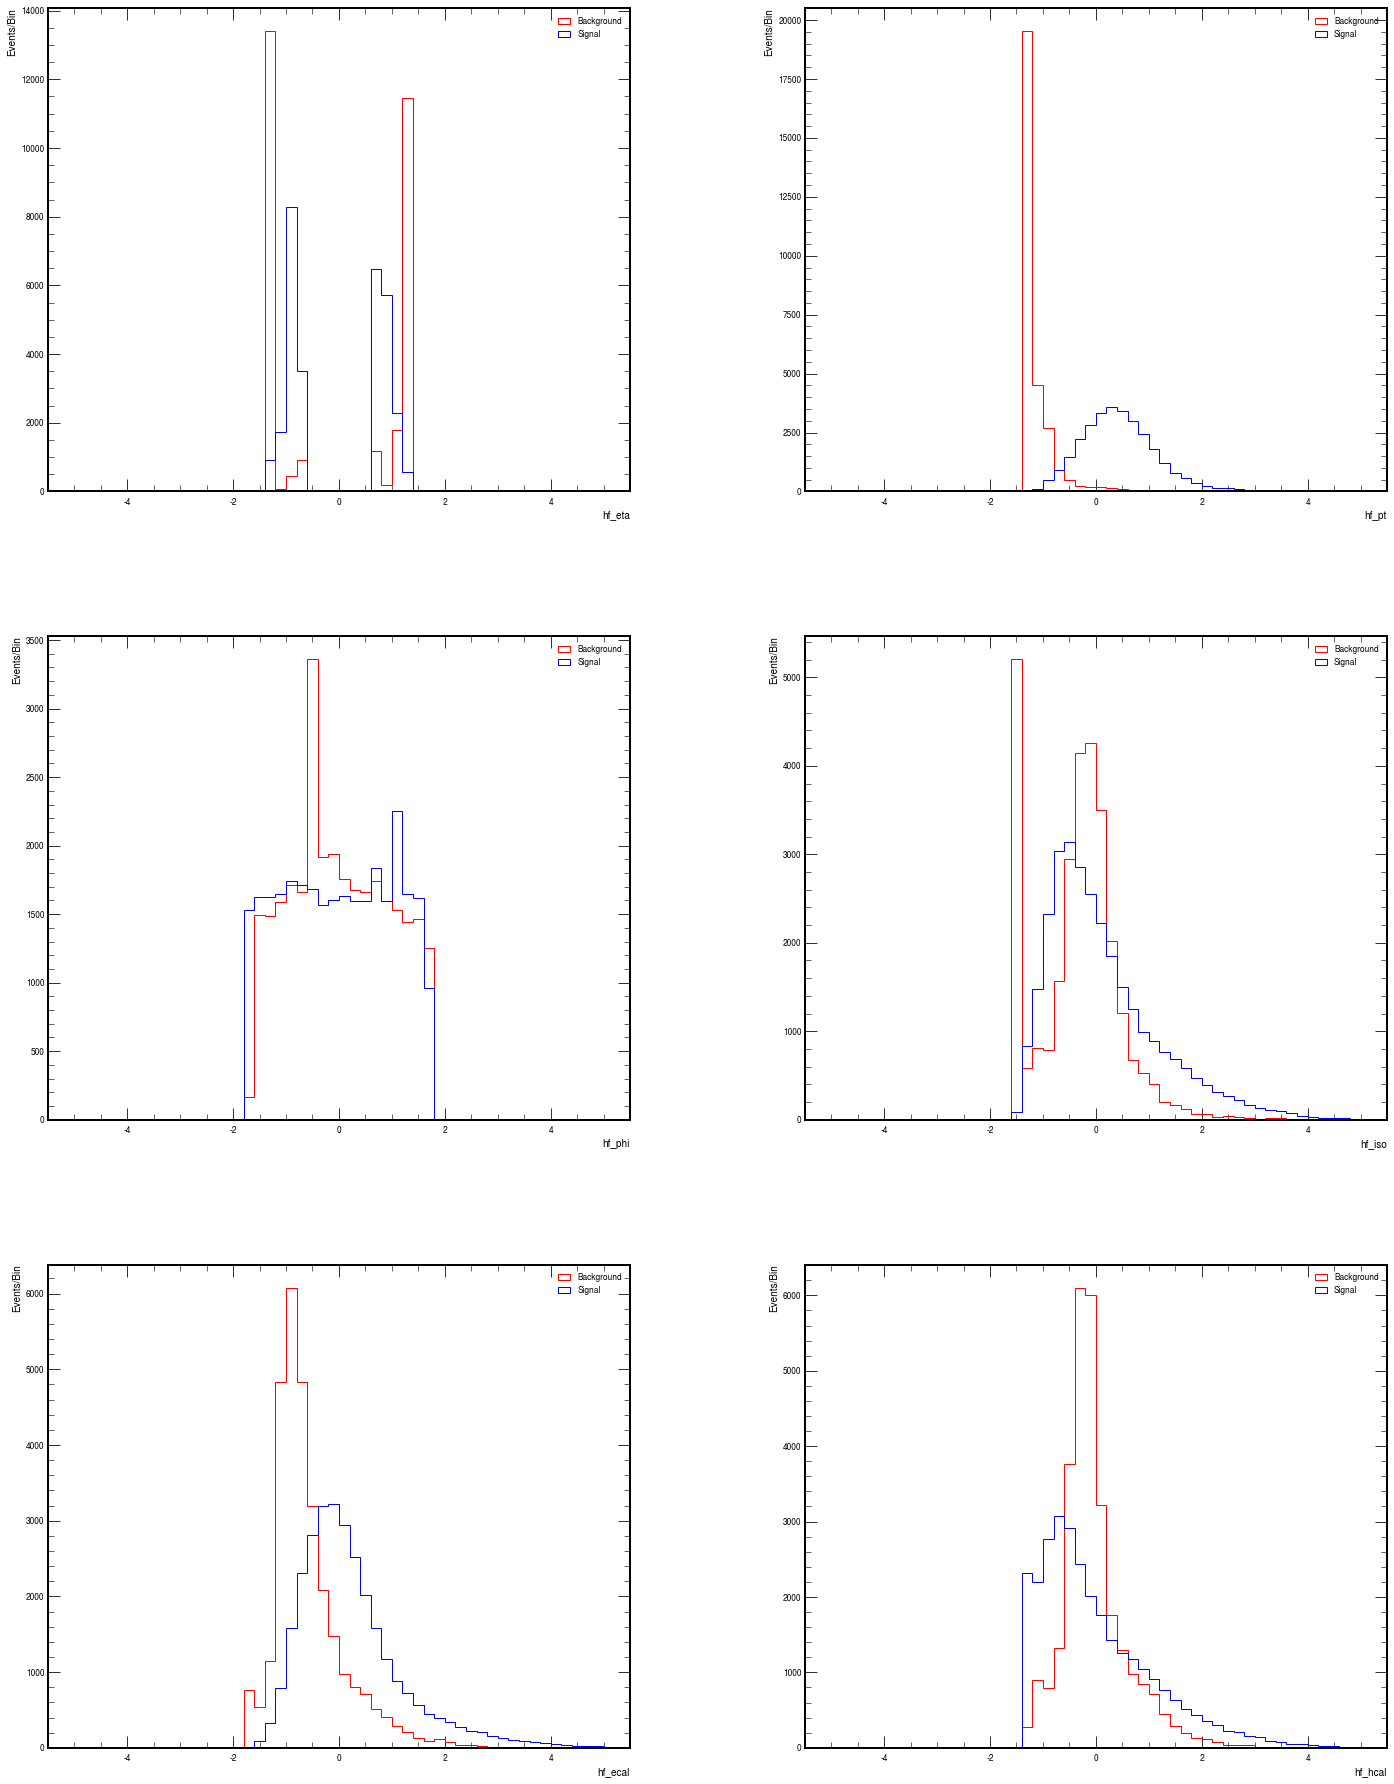

Created Plot: varplots


<Figure size 432x288 with 0 Axes>

<Figure size 864x1152 with 0 Axes>

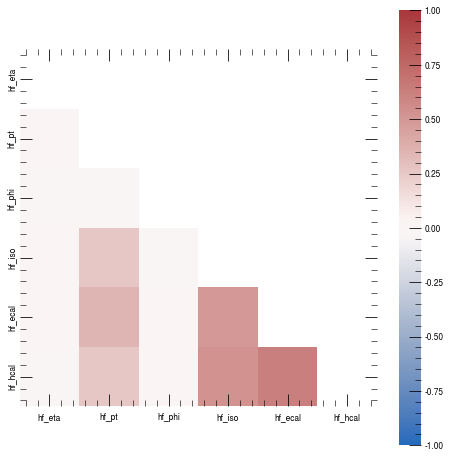

Created Plot: CorrelationMatrix_Background


<Figure size 432x288 with 0 Axes>

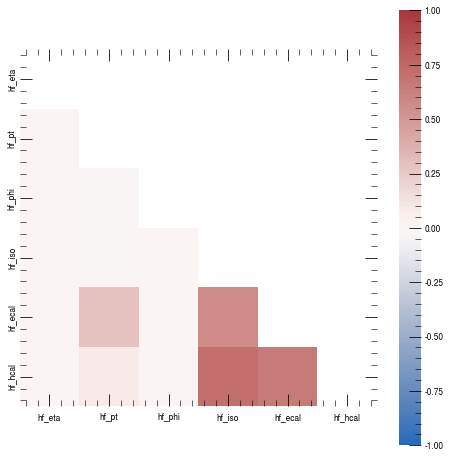

Created Plot: CorrelationMatrix_Signal
[[ 0.97216528  0.86767878 -0.54740933  0.5232009   0.25674859  1.86161883]
 [ 1.18760466 -0.64239774  1.53466064  1.81131797  1.06609263  1.01181868]
 [ 0.92835251  0.31590248  0.32480637 -0.45639163  0.03164543  0.3239033 ]
 ...
 [ 0.75414337  0.15603353 -0.06283923 -0.70616764 -0.65047458 -0.90756322]
 [-1.26545945 -1.34764823 -0.20819822 -0.06585554 -1.01049007 -0.26207673]
 [-0.98799346  0.31407541  0.71223488  1.04983544  0.25338789  0.75486489]] [[ 0.71208346  0.81063357 -1.32789258 -1.13841886  0.04771549 -1.23796131]
 [-0.85877512  0.22637587 -0.93472959  0.35215724 -0.42003859 -0.38194711]
 [-1.16211193  0.14872523  0.51919792  2.91369372  1.85001188  2.77366302]
 ...
 [-0.81392024  2.09912654  0.51833077 -0.38635538  0.91561006  0.01839384]
 [ 1.24618796 -0.91006405  0.56828284 -0.58478715  0.41243384  1.20398061]
 [ 0.72246262  0.23509952  1.70123299 -0.95140413 -0.32076127 -1.28833779]] [1. 1. 1. ... 1. 0. 1.] [1. 1. 1. ... 1. 1. 1.] [

<Figure size 432x288 with 0 Axes>

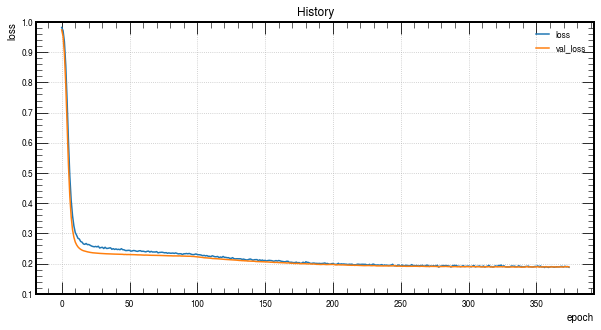

Created Plot: historyLoss


<Figure size 432x288 with 0 Axes>

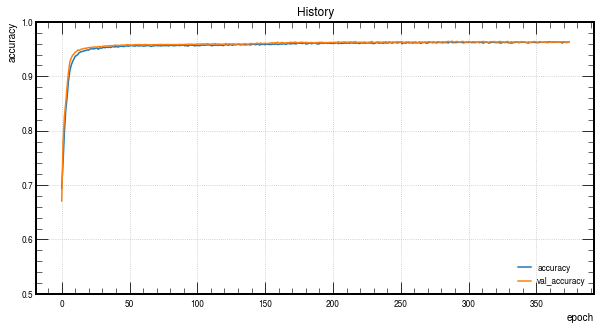

Created Plot: historyAccuracy
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step


<Figure size 432x288 with 0 Axes>

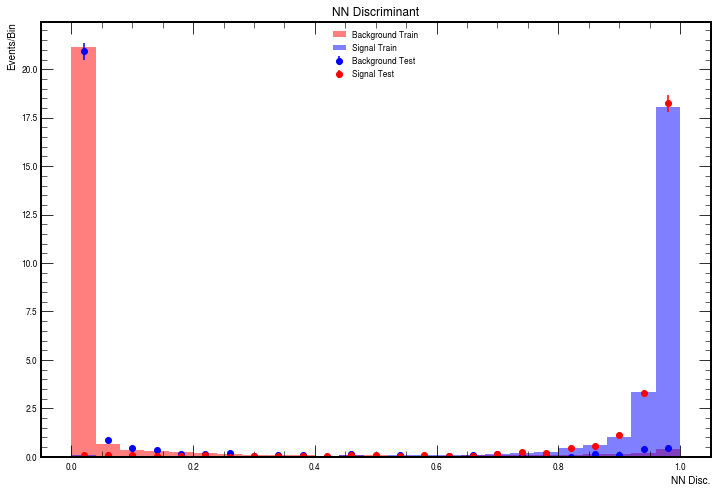

Created Plot: NN_disc
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step


<Figure size 432x288 with 0 Axes>

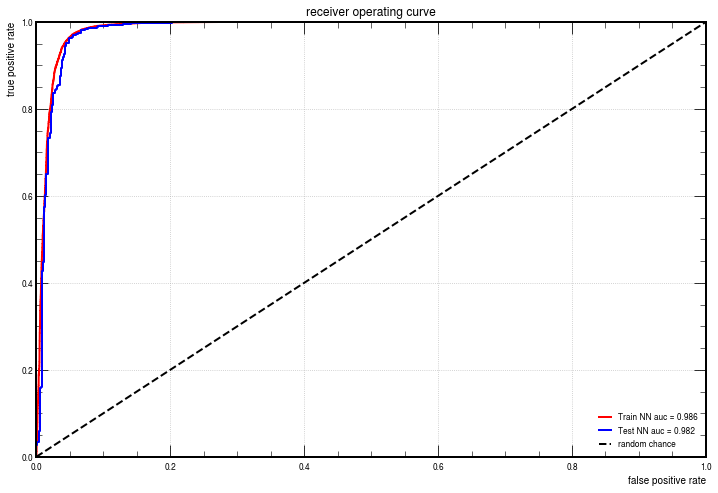

Created Plot: ROC_curve


<Figure size 432x288 with 0 Axes>

In [11]:
modelName  = 'testModel_v1'
input      = store # the output of preprocesses()
signal     = 'SignalWJetsTo3Pi.*FT' 
background = 'Tau_Run'
dont_plot  = False # skip the plotting of variables
just_plot  = False # just plot the variable distributions, don't train
log        = False # make plots in log scale
dev_model  = False # use alternate model architecture
split      = True # only train on half the events (applies to data only)

mplhep.style.use("CMS")
training_variables  = ['hf_eta', 'hf_pt', 'hf_phi', 'hf_iso', 'hf_ecal', 'hf_hcal']

# Train the model and save some outputs
trained_model, training_data, training_labels = train(modelName, input, 
                                                      signal=signal, 
                                                      background=background, 
                                                      training_vars=training_variables, 
                                                      dont_plot=dont_plot, 
                                                      just_plot=just_plot, 
                                                      log=log, 
                                                      dev_model=dev_model, 
                                                      split=split,
                                                      cutflow=True
                                                     )

In [12]:
#trained_model.save('testModel_v1.hdf5', save_format="hdf5")
#trained_model.save('testModel_v1.h5', save_format='h5')
# trained_model.save('testModel_v1_savedmodel.tf')
#trained_model.export('testModel_v1_savedmodel')
trained_model.save('testModel_v1.keras')

In [14]:
#Do not change this

class Predictor:
    def __init__(self, data_name, model_name, keep):
        self.keep = keep
        self.selected = pd.DataFrame()
        self.data = data_name
        self.model = model_name
        self.mean = -1

    def make_prediction(self, fname, syst='miniTree'):
        self.current_data = self.data[syst] # read correct tree
        self.selected = self.selected.iloc[0:0] # clear selected
        self.selected = self.current_data[
            (self.current_data['sample_names'] == fname) # & (self.current_data['lepton'] == channel)
        ].copy()
        if len(self.selected[self.keep].values) == 0:
            raise Exception(f'No events to classify!!!\nCheck that fname: {fname} is in your dataset: {np.unique(self.current_data["sample_names"])}')
        guesses = self.model.predict(self.selected[self.keep].values, verbose=True)
        self.selected['guess'] = guesses
        self.mean = guesses.mean()
        self.selected.set_index('idx', inplace=False)

    def predict_all(self, syst='miniTree'):
        return self.model.predict( self.data[syst][self.keep].values, verbose=True)

    def getGuesses(self):
        return self.selected['guess']

    def getIndices(self):
        return self.selected['idx']

    def getGuess(self, index):
        try:
            guess = self.selected.loc[index, 'guess']
        except:
            guess = -999
        return guess

In [15]:
# class Predictor:
#     def __init__(self, data_name, model_name, keep):
#         self.keep = keep
#         self.selected = pd.DataFrame()
#         self.data = data_name
#         self.model = model_name
#         self.mean = -1

#     def make_prediction(self, fname, syst='miniTree'):
#         self.current_data = self.data[syst] # read correct tree
#         print(self.current_data)
#         self.selected = self.selected.iloc[0:0] # clear selected
        
#         if "data" in fname.lower():
#             # For data, use the entire dataset even if the sample name is not matching.
#             self.selected = self.current_data.copy()
#             # Use all events for prediction (ignore hf_match selection).
#             keep_mask = np.ones(len(self.selected), dtype=bool)
#         else:
#             # For MC, filter using the sample_names.
#             self.selected = self.current_data[self.current_data['sample_names'] == fname].copy()
#             keep_mask = self.keep

#         if len(self.selected[keep_mask].values) == 0:
#             raise Exception(
#                 f'No events to classify!!!\nCheck that fname: {fname} is in your dataset: {np.unique(self.current_data["sample_names"])}'
#             )
        
#         guesses = self.model.predict(self.selected[self.keep].values, verbose=True)
#         self.selected['guess'] = guesses
#         self.mean = guesses.mean()
#         self.selected.set_index('idx', inplace=False)

#     def predict_all(self, syst='miniTree'):
#         return self.model.predict( self.data[syst][self.keep].values, verbose=True)

#     def getGuesses(self):
#         return self.selected['guess']

#     def getIndices(self):
#         return self.selected['idx']

#     def getGuess(self, index):
#         try:
#             guess = self.selected.loc[index, 'guess']
#         except:
#             guess = -999
#         return guess

In [16]:
from ROOT import TFile, TTree
from array import array

def fillFile(ifile, sig_pred, verbose=False):
    # fname = ifile.split('/')[-1].replace('.root', '').replace('file:', '')
    fname =  ifile.split('/')[-1].split('.root')[0]
    if verbose: print(f'\n\t*** Starting process for file: {fname}')

    root_file = TFile(ifile, 'READ')

    outfile = 'outputs/' + ifile.split('/')[-1].split('.root')[0] + '_output.root'
    fout = TFile( outfile, 'RECREATE')  # make new file for output
    keylist = root_file.GetListOfKeys().Clone()
    fout.cd()
    
    # now let's try and get this into the root file
    if verbose: print(f'Reading input file {ifile}')
    for ikey in keylist:
        #if not 'miniTree' in ikey.GetName() and not 'events' in ikey.GetName():
        if not 'miniTree' in ikey.GetName():
            continue
        
        itree = root_file.Get(ikey.GetName())
        syst_label = ikey.GetName()

        fout.cd()
        ntree = itree.CloneTree(-1, 'fast')
        nevts = ntree.GetEntries()
        if nevts == 0:
            print(f'{fname} has ZERO entries')
            keylist = fout.GetListOfKeys().Clone()
            keyNames = [ ikey.GetName() for ikey in keylist]
            if 'miniTree' not in keyNames:
                print(f'No TTree named "Events" in {outfile}... adding empty tree')
                tree = TTree("miniTree", "miniTree")
                tree.Write()
                return outfile

        # a little silly... or smart??
        maxTrips = -1
        for entry in ntree:
            trips = getattr( entry, "nhf")
            if trips > maxTrips:
                maxTrips = trips

        # Now we can use this to define the 'fixed' array size
        ntrips = maxTrips
        fout.cd()
        N = array('f', [ 0. ])
        itree.SetBranchAddress('nhf', N)
        
        branch_idx = array('i', [0])
        idx_branch = ntree.Branch('idx', branch_idx, 'idx/I')
        branch_var = array('f', ntrips*[ 0. ])
        disc_branch = ntree.Branch('hf_NN_disc', branch_var, 'hf_NN_disc[nhf]/F')
        if nevts == 0:
            print(f'No events in file: {ifile} ...writing empty file!!!')
        else:
            print(f'{fname}, {nevts},{syst_label}')
            #sig_pred.make_prediction(fname, syst_label)    
            sig_pred.predict_all(syst_label) 
            # Little debug thing... can check NN disc distribution
            # if verbose:
            #     plt.figure(figsize=(6, 4)) # 6, 4
            #     plt.title(fname)
            #     temp_pred = sig_pred.selected
            #     temp_pred['guess'] = sig_pred.getGuesses()
            #     temp_pred['idx'] = sig_pred.getIndices()
            #     cuts = (temp_pred['Trigger_ditau']) & (temp_pred['METfilters']) & ~(temp_pred['LeptonVeto'])
            #     cuts = cuts & (temp_pred['PionTriplet_trailingIsTrack']) & (abs(temp_pred['PionTriplet_charge']) == 3)
            #     cuts = cuts & (temp_pred['PionTriplet_pion1_DM'] == 0) & (temp_pred['PionTriplet_pion2_DM'] == 0) 
            #     slim_temp_pred = temp_pred[cuts]
            #     #slim_temp_pred = temp_pred[(temp_pred['idx'] % 2 ) == 0]
            #     print(slim_temp_pred[['event','guess', 'PionTriplet_MassInv_Full', 'PionTriplet_pt_Full']])
            #     if (slim_temp_pred.empty):
            #         raise Exception(f'No events in training phase space for file: {ifile}')
            #     print(f'Triplets in training phase space: {len(slim_temp_pred["guess"])}')
            #     plt.hist( slim_temp_pred['guess'], color='black', bins=50, range=(0, 1))
            #     plt.show()
            #     plt.clf()

        if verbose: print(f'Looping {nevts} events')

        ntrips = uproot.open(ifile)["miniTree"].arrays('nhf', library="ak")['nhf']
        flat_guesses = ak.unflatten( sig_pred.getGuesses(), ntrips).to_list()
        flat_indices = ak.unflatten( sig_pred.getIndices(), ntrips).to_list()
        
        for evt_index, entry in enumerate(ntree):
            fout.cd()
            # for reasons beyond my comprehension, this needs to be set iteritively, like so
            # if not, the values are all 0 in the ROOT file... might be something with datatypes
            for i, guess in enumerate(flat_guesses[evt_index]):
                branch_var[i] = guess
            branch_idx[0] = int(flat_indices[evt_index][0])
            fout.cd()
            idx_branch.Fill()
            disc_branch.Fill()

        fout.cd()
        if verbose: print(f'writing tree {ntree.GetName()}')
        ntree.Write()

    root_file.Close()
    fout.Close()

    if verbose: print(f'{fname} Completed.')
    return outfile

In [17]:
dataset = store # here we **MUST** use the same set of data that we pulled our training data from!
#variablePlots_single( 'Classify', pd.DataFrame(dataset['Events']), training_variables)

sig_pred = Predictor( dataset, trained_model, training_variables)

columns = scaled_vars + selection_vars +  ['idx', 'sample_names', 'evtwt']
classified_events = unclassified_events['miniTree'][columns].copy()
classified_events.loc[:, 'hf_NN_disc'] = sig_pred.predict_all(syst='miniTree')
                                
#ntrips = ak.run_lengths(unclassified_events['Events']['idx']) # save this for later...

12982/12982 ━━━━━━━━━━━━━━━━━━━━ 11s 849us/step


In [18]:
#print(classified_events)

In [ ]:
import datetime

output_pred = Predictor( store, trained_model, training_variables)

files_to_process = [
    # *** SIGNAL SAMPLES *** 
    #'/eos/user/d/dmroy/W3piSamples/Wto3pi_2016_preVFP/Wto3pi/SignalWJetsTo3Pi_Plus_Wto3pi*.root',
    #'/eos/user/d/dmroy/W3piSamples/Wto3pi_2016_preVFP/Wto3pi/SignalWJetsTo3Pi_Minus_Wto3pi*.root',
    #'/eos/user/d/dmroy/W3piSamples/Wto3pi_2016_postVFP/Wto3pi/SignalWJetsTo3Pi_Plus_Wto3pi*.root',
    #'/eos/user/d/dmroy/W3piSamples/Wto3pi_2016_postVFP/Wto3pi/SignalWJetsTo3Pi_Minus_Wto3pi*.root',
    #'/eos/user/d/dmroy/W3piSamples/Wto3pi_2017/Wto3pi/SignalWJetsTo3Pi_Plus_Wto3pi*.root',
    #'/eos/user/d/dmroy/W3piSamples/Wto3pi_2017/Wto3pi/SignalWJetsTo3Pi_Minus_Wto3pi*.root',
    #'/eos/user/d/dmroy/W3piSamples/Wto3pi_2018/Wto3pi/SignalWJetsTo3Pi_Plus_Wto3pi*.root', 
    #'/eos/user/d/dmroy/W3piSamples/Wto3pi_2018/Wto3pi/SignalWJetsTo3Pi_Minus_Wto3pi*.root', 
    # *** DATA SAMPLES *** 
    #'/eos/user/n/naislam/HFCalibration/2024/2024H/Untuplizer/EGamma1_Run2024H/output_data_EGamma1_Run2024H_6751916_1.root',
    # '/eos/user/n/naislam/HFCalibration/2024/2024H/Untuplizer/EGamma1_Run2024H/output_data_EGamma1_Run2024H_6751916_2.root',
    # '/eos/user/n/naislam/HFCalibration/2024/2024H/Untuplizer/EGamma1_Run2024H/output_data_EGamma1_Run2024H_6751916_3.root',
    # '/eos/user/n/naislam/HFCalibration/2024/2024H/Untuplizer/EGamma1_Run2024H/output_data_EGamma1_Run2024H_6751916_4.root',
    # '/eos/user/n/naislam/HFCalibration/2024/2024H/Untuplizer/EGamma1_Run2024H/output_data_EGamma1_Run2024H_6751916_5.root',
    '/eos/user/n/naislam/HFCalibration/2024/2024H/Untuplizer/EGamma1_Run2024H/output_data_EGamma1_Run2024H_6751916_6.root',
    #'/eos/user/n/naislam/HFCalibration/2024/2024H/Untuplizer/EGamma1_Run2024H/output_data_EGamma1_Run2024H_6751916_5.root'
    #'/eos/user/d/dmroy/W3piSamples/Wto3pi_2016_preVFP/Data/*.root',
    #'/eos/user/d/dmroy/W3piSamples/Wto3pi_2016_postVFP/Data/*.root',
    #'/eos/user/d/dmroy/W3piSamples/Wto3pi_2017/Data/*.root',
    #'/eos/user/d/dmroy/W3piSamples/Wto3pi_2018/Data/*.root',
    #'/eos/user/j/jnatoli/W3piSamples/Wto3pi_2022_preEE/Data/*.root',
    #'/eos/user/j/jnatoli/W3piSamples/Wto3pi_2022_postEE/Data/*.root',
    #'/eos/user/j/jnatoli/W3piSamples/Wto3pi_2023_preBPix/Data/*.root',
    #'/eos/user/j/jnatoli/W3piSamples/Wto3pi_2023_postBPix/Data/*.root',
    # *** MC SAMPLES *** 
    #'/eos/user/d/dmroy/W3piSamples/Wto3pi_2016_preVFP/DY/DYJetsToLL_M-50_NLO_Wto3pi*.root',
    #'/eos/user/d/dmroy/W3piSamples/Wto3pi_2016_postVFP/DY/DYJetsToLL_M-50_NLO_Wto3pi*.root',
    #'/eos/user/d/dmroy/W3piSamples/Wto3pi_2017/DY/DYJetsToLL_M-50_NLO_Wto3pi*.root',
    #'/eos/user/d/dmroy/W3piSamples/Wto3pi_2018/DY/DYJetsToLL_M-50_NLO_Wto3pi*.root',
    #'/eos/user/d/dmroy/W3piSamples/Wto3pi_2018/TT/*.root',
    #'/eos/user/j/jnatoli/W3piSamples/Wto3pi_2022_preEE/DY/DYJetsToLL_M-50_NLO_Wto3pi*.root',
    #'/eos/user/j/jnatoli/W3piSamples/Wto3pi_2022_postEE/DY/DYJetsToLL_M-50_NLO_Wto3pi*.root',
    #'/eos/user/j/jnatoli/W3piSamples/Wto3pi_2023_preBPix/DY/DYJetsToLL_M-50_NLO_Wto3pi*.root',
    #'/eos/user/j/jnatoli/W3piSamples/Wto3pi_2023_postBPix/DY/DYJetsToLL_M-50_NLO_Wto3pi*.root',
]

start_time = datetime.datetime.now()
outfiles = [ fillFile(ifile, output_pred) for ifile in expandGlob(files_to_process)]
end_time = datetime.datetime.now()

print(f'\nTime to classify: {(end_time - start_time).total_seconds():.2f} seconds')

print(outfiles)

In [ ]:
# trained_model.save('models/testModel_v1.keras')

In [ ]:
import uproot
import pandas as pd

def root_to_dataframe(root_file_path, tree_name):
    with uproot.open(root_file_path) as file:
        tree = file[tree_name]
        array = tree.arrays(library="np")
    return array

In [ ]:
array_1 = root_to_dataframe ('/eos/user/n/naislam/HFCalibration/2024/2024H/Untuplizer/output_mc.root', "miniTree")
df_1 = pd.DataFrame(array_1)
#print(df_1.head())

In [ ]:
classified_events_cut = classified_events[classified_events['hf_NN_disc'] > 0.9]
#print (classified_events_cut)

In [ ]:
df_new = classified_events_cut.merge(df_1[['event', 'nele', 'ele_pt', 'ele_eta', 'ele_phi', 'ele_mediumID']], on='event', how='left')

print(df_new)

/tmp/ipykernel_472/457093529.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ele.SetPtEtaPhiM(ele_pt, ele_eta, ele_phi, 0)


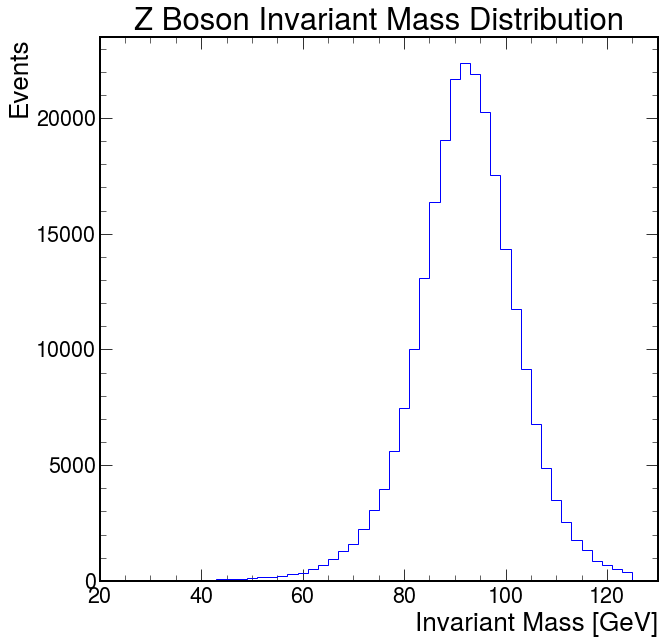

In [122]:
import ROOT
import matplotlib.pyplot as plt

invariant_masses = []

for _, row in df_new.iterrows():
    if row['nele'] > 1:
        ele_pt = row['ele_pt'][0]
        ele_eta = row['ele_eta'][0]
        ele_phi = row['ele_phi'][0]
    else:
        ele_pt = row['ele_pt'] if not isinstance(row['ele_pt'], (list, tuple)) else row['ele_pt'][0]
        ele_eta = row['ele_eta'] if not isinstance(row['ele_eta'], (list, tuple)) else row['ele_eta'][0]
        ele_phi = row['ele_phi'] if not isinstance(row['ele_phi'], (list, tuple)) else row['ele_phi'][0]

    ele = ROOT.TLorentzVector()
    ele.SetPtEtaPhiM(ele_pt, ele_eta, ele_phi, 0)

    hf = ROOT.TLorentzVector()
    hf.SetPtEtaPhiM(row['hf_pt'], row['hf_eta'], row['hf_phi'], 0)

    z_candidate = ele + hf
    invariant_masses.append(z_candidate.M())

plt.hist(invariant_masses, bins=50, range=(25, 125), histtype='step', color='blue')
plt.xlabel('Invariant Mass [GeV]')
plt.ylabel('Events')
plt.title('Z Boson Invariant Mass Distribution')
plt.show()